In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as utils
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# set seed
torch.manual_seed(42)
np.random.seed(42)


In [2]:
from typing import Tuple, List, Callable
from torch.distributions import Distribution
from sklearn.preprocessing import StandardScaler
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
from sklearn import metrics
from tqdm import tqdm
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
from IPython.display import clear_output

from sklearn.datasets import make_moons

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# https://sebastiancallh.github.io/post/affine-normalizing-flows/
# uses Real NVP paper

# Define the Normalizing Flow model template
class NormalizingFlow(nn.Module):

    def __init__(self, latent: Distribution, flows: List[nn.Module]):
        super(NormalizingFlow, self).__init__()
        self.latent = latent
        self.flows = nn.ModuleList(flows)

    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:
        return self.latent.log_prob(z)

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        return self.latent.sample((num_samples,))

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        '''Sample a new observation x by sampling z from
        the latent distribution and pass through g.'''
        return self.g(self.latent_sample(num_samples))

    def f(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        '''Maps observation x to latent variable z.
        Additionally, computes the log determinant
        of the Jacobian for this transformation.
        Inverse of g.'''
        #z, sum_log_abs_det = x, torch.zeros(x.size(0)).to(device) # change to x device
        z, sum_log_abs_det = x, torch.zeros(x.size(0), device = x.device)
        for flow in self.flows:
            z, log_abs_det = flow.f(z)
            sum_log_abs_det += log_abs_det

        return z, sum_log_abs_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''Maps latent variable z to observation x.
        Inverse of f.'''
        with torch.no_grad():
            x = z
            #x = z.to(self.flows[0].theta[0][0].weight.device)
            for flow in reversed(self.flows):
                x = flow.g(x)

        return x

    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:
        '''Maps latent variable z to observation x
        and stores intermediate results.'''
        xs = [z]
        for flow in reversed(self.flows):
            xs.append(flow.g(xs[-1]))

        return xs

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        '''Computes log p(x) using the change of variable formula.'''
        z, log_abs_det = self.f(x)
        return self.latent_log_prob(z) + log_abs_det

    def __len__(self) -> int:
        return len(self.flows)


class AffineCouplingLayer(nn.Module):

    def __init__(self, theta: nn.Module, split: Callable[[torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]):
        super(AffineCouplingLayer, self).__init__()
        self.theta = theta
        self.split = split

    def f(self, x: torch.Tensor) -> torch.Tensor:
        '''f: x -> z. The inverse of g.'''
        x2, x1 = self.split(x) # flip the split #insert other permutation for 3D+ data
        ### permutation at one point
        t, s = self.theta(x1)
        # Tau coupling function: e^s + t
        z1, z2 = x1, x2 * torch.exp(s) + t
        log_det = s.sum(-1) # sum over the last dimension
        return torch.cat((z1, z2), dim=-1), log_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''g: z -> x. The inverse of f.'''
        z1, z2 = self.split(z)
        t, s = self.theta(z1)
        x1, x2 = z1, (z2 - t) * torch.exp(-s)
        return torch.cat((x2, x1), dim=-1)


class Conditioner(nn.Module):
    'The conditioner is the Neural Network that helps fit the model to the data by learning theta_i = (s_i,t_i)'

    def __init__(self, in_dim: int, out_dim: int, num_hidden: int, hidden_dim: int, num_params: int):
        super(Conditioner, self).__init__()
        self.input = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  
            nn.LeakyReLU(inplace=True)  
        )
        self.hidden = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),  
                nn.Dropout(0.3),
                nn.LeakyReLU(inplace=True)  
            )
            for _ in range(num_hidden)
        ])

        self.num_params = num_params
        self.out_dim = out_dim
        self.output = nn.Linear(hidden_dim, out_dim * num_params)
        # initialisere output lag conditioner alle vægte og bias til 0
        nn.init.zeros_(self.output.weight)
        nn.init.zeros_(self.output.bias) 

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.input(x)
        for h in self.hidden:
            x = h(x)

        batch_params = self.output(x).reshape(x.size(0), self.out_dim, -1)
        #batch_params[:,:,1] *= 0.001
        #batch_params[:,:,0] *= 0.001 
        params = batch_params.chunk(self.num_params, dim=-1)
        return [p.squeeze(-1) for p in params]

class CNN(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        
        super(CNN, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(32, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, latent_dim)
        self.batchnorm = nn.BatchNorm1d(latent_dim) #num_classes
        ## Afprøve:
        # learning rate scheduler
        # rapport
        # Langt tid senere: korrekte usikkerheder senere
        # plot i datarummet - meshgrid - normaliseret alpha eller flows

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.batchnorm(x)
        return x

In [5]:
class PosteriorNetwork(nn.Module):
    def __init__(self, latent_dim: int, flow_models: List[nn.Module], N: torch.tensor, num_classes: int, y: torch.Tensor):
        super(PosteriorNetwork, self).__init__()
        self.cnn = CNN(latent_dim)
        self.flow_models = nn.ModuleList(flow_models)
        self.N = N
        self.y = y
        self.num_classes = num_classes 
    
    def forward(self, x, N):
        batch_size = x.size(0)
        # N is number of inputs in each class total
        z = x
        #z = self.cnn(x)
        # for each class, since outputdim = num_classes
        alpha = torch.zeros((batch_size, self.num_classes)).to(z.device.type)
        log_q = torch.zeros((batch_size, self.num_classes)).to(z.device.type)
        beta_i = torch.zeros((batch_size, self.num_classes)).to(z.device.type)

        for c in range(self.num_classes):
            log_prob = self.flow_models[c].log_prob(z)
            log_q[:,c] = log_prob
            beta_prior = 1 
            beta_i[:,c] = N[c] * torch.exp(log_prob)  #formula (4) from paper
            alpha[:,c] = beta_prior + beta_i[:,c] #or just beta_i[c]?

        # grad_loss
        #loss = self.loss_postnet(alpha, y, batch_size)

        ##alpha = F.normalize(alpha, p=1, dim=1) # to get p^bar_c which is the average of alphas
        #preds = self.predict(alphas) #categorical prediction using argmax on p_bar_c
        return alpha

    def loss_postnet(self, alpha, y, batch_size): #UCE loss 
        #alpha is the p vector with alphas for each class
        #y_hot is the ground-truth class labels
        alpha_0 = torch.sum(alpha, dim=1, keepdim=True) #batch x 1
        digamma_alpha_c = torch.digamma(alpha[range(batch_size),y]) # batch x 1

        digamma_alpha_0 = torch.digamma(alpha_0) # batch x 1, hver obs får sin egent logprobs
        uce_loss = digamma_alpha_c - digamma_alpha_0 #elementwise
        #uncertain_loss = torch.sum((digamma_alpha_c - digamma_alpha_sum) * alpha, dim=1)
        
        # entropy in Dirichlet distribution
        uce_loss = -torch.mean(uce_loss) #negative since we want to minimize the loss
        #approximates the true posterior distribution for the categorical distribution p
        return uce_loss

In [6]:
from torch.utils.data import DataLoader, TensorDataset
# Generate the "make_moons" dataset
X, y = make_moons(n_samples=2000, noise=0.1, random_state=42)

# 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# Dictionary with class names
classes = {0: "Class 0", 1: "Class 1"}

# Initialize dictionary to store the counts for each class
N = {class_idx: (y_train == class_idx).sum().item() for class_idx in classes}
N = torch.tensor([N[class_idx] for class_idx in classes])

# Print class counts and class names
print(N)
print(classes)

tensor([803, 797])
{0: 'Class 0', 1: 'Class 1'}


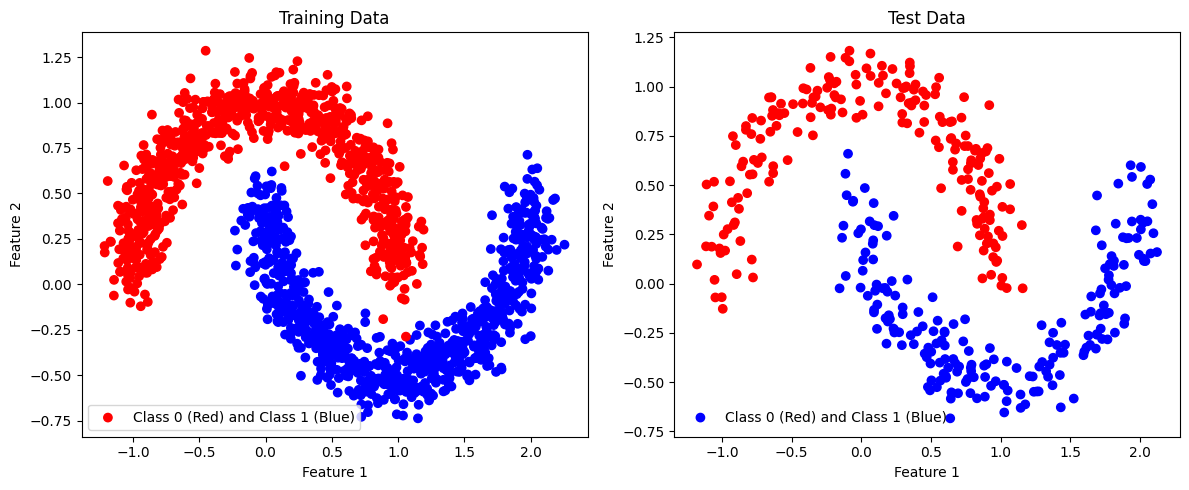

In [7]:
# Plot the "make_moons" dataset
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
colors = ['r' if label == 0 else 'b' for label in y_train]
# Plot training data
axes[0].scatter(X_train[:, 0], X_train[:, 1], c=colors, label='Class 0 (Red) and Class 1 (Blue)')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].legend(loc='lower left', frameon=True, labelcolor='black')  # Adjust legend properties
axes[0].set_title('Training Data')
# Plot test data
colors = ['r' if label == 0 else 'b' for label in y_test]
axes[1].scatter(X_test[:, 0], X_test[:, 1], c=colors, label='Class 0 (Red) and Class 1 (Blue)')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].legend(loc='lower left', frameon=False, labelcolor='black', numpoints = 1, shadow = True)  # Adjust legend properties
axes[1].set_title('Test Data')
plt.tight_layout()
plt.show()

In [8]:
num_classes = 2
latent_dim = 2 # the encoder outputs 2D latent space
data_dim = 2 # the encoder outputs 2D latent space
in_dim= data_dim // 2 # since we split the data
out_dim= data_dim // 2
num_params = 2 # s and t
num_hidden = 2 # number of hidden layers
hidden_dim = 32 # neurons in hidden layers
num_flows = 4 # number of coupling flow layers

lr = 0.0003 # 0.0003 og 4x epochs
weight_decay = 1e-4  # L2 regularization strength to prevent overfitting in Adam or AdamW 
num_epochs = 70 # flere epochs maybe 12000    #16000
batch_size = 32
#validation_every_steps = 10
validation_every_epochs = 5
early_stop_delta = 0.001
early_stop_patience = 10


flow_models = []
for class_label in range(num_classes):
    conditioner = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, hidden_dim=hidden_dim, num_params=num_params)
    affine_coupling = AffineCouplingLayer(conditioner, split=lambda x: x.chunk(2, dim=-1)) # split the tensor into 2 parts
    flows = [affine_coupling for _ in range(num_flows)]
    latent_distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(data_dim).to(device), scale_tril=torch.eye(data_dim).to(device))

    flow_model = NormalizingFlow(latent_distribution, flows).to(device)
    #flow_model = NormalizingFlow(latent_distribution, flows).apply(init_weights).to(device)
    flow_models.append(flow_model)

postnet_model = PosteriorNetwork(latent_dim, flow_models, N, num_classes, y_train).to(device) 
optimiser = optim.AdamW(postnet_model.parameters(), lr=lr, weight_decay=weight_decay)

In [9]:
############## TRAINING ######################
##############################################
def accuracy(y_train, preds):
    accuracy = accuracy_score(y_train.cpu().numpy(), preds.cpu().numpy())
    return accuracy

####### TO DO : #######
## Implement learning rate scheduling - adaptive learning rate during training: step_decay, learning rate annealing or learning rate scheduler
## - dividere med 10 på et tidspunkt

## Use a hyperparameter tuning library like Optuna or GridSearchCV to automate the search process.
## Cross-validation - implement a k-fold cross-validation to evaluate the model performance on the training data.
## Check normalisation of data
## Check regularization strength - e.g. weight decay or dropout
## Ensemble Methods: If applicable, consider using ensemble methods like bagging or boosting by training multiple models and combining their predictions.


def train(model, optimiser, train_loader, test_loader, num_epochs, validation_every_epochs, early_stop_delta, early_stop_patience):
    model.train()
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    all_train_losses = []
    best_val_loss = float("Inf")
    step = 0
    counter = 0
    for epoch in range(num_epochs):

        train_losses_batches, train_accuracies_batches = [], []

        # batches_counter = 0
        for batch_index, (X_train, y_train) in enumerate(train_loader):
            X_train, y_train = X_train.to(device), y_train.to(device)
            
            # batches_counter += 1
            # print(f"Batch: {batches_counter}")
            # print("batch size: ", X_train.size(0))
            # Forward pass
            alpha = model(X_train, N)
            loss = model.loss_postnet(alpha, y_train, X_train.size(0)) #batch size
            # Perform one training step
            optimiser.zero_grad()
            loss.backward()
            #utils.clip_grad_norm_(flow_model.parameters(), max_norm=5.0)
            optimiser.step()
            step += 1
            #train_losses.append(loss.item())

            # Compute training accuracy and loss for this batch
            with torch.no_grad():
                alphas_norm = F.normalize(alpha, p=1, dim=1) 
                preds = torch.max(alphas_norm, dim=-1)[1]
                train_accuracies_batches.append(accuracy(y_train, preds))
                train_losses_batches.append(loss.item())
                #batch_accuracy = accuracy_score(y_train.cpu().numpy(), preds.cpu().numpy())
                #train_accuracies.append(batch_accuracy)
                all_train_losses.append(loss.item())

        if epoch % validation_every_epochs == 0:
            train_losses.append(np.mean(train_losses_batches))
            train_accuracies.append(np.mean(train_accuracies_batches))

            val_losses_batches = []
            #val_accuracies_batches = []
            val_correct = []
            model.eval()
            with torch.no_grad():   
                for batch_index, (X_test, y_test) in enumerate(test_loader):
                    X_test, y_test = X_test.to(device), y_test.to(device)
                    # Evaluation Forward pass
                    alpha = model(X_test, N) # gives a vector with alphas for each class
                    loss = model.loss_postnet(alpha, y_test, X_test.size(0)) #gives a loss
                    
                    # Evaluation accuracy and loss for this batch
                    alphas_norm = F.normalize(alpha, p=1, dim=1)
                    preds = torch.max(alpha, dim=-1)[1]
                    
                    correct_batch = (preds == y_test).sum().item()
                    val_correct.append(correct_batch)

                    #Maybe: Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    #val_accuracies_batches.append(accuracy(y_test, preds) * len(X_test))

                    # append the loss for this batch
                    val_losses_batches.append(loss.item())

            val_accuracy = sum(val_correct) / len(test_dataset) 
            val_accuracies.append(val_accuracy)

            val_loss = np.mean(val_losses_batches) 
            val_losses.append(val_loss)
            #val_losses.append(np.mean(val_losses_batches))
            #val_accuracies.append(np.sum(val_accuracies_batches) / len(test_dataset))   

            if val_losses[-1] < -1.:
                print("Unstable training")
                break
            if np.isnan(val_losses[-1]):
                print('Detected NaN Loss')
                break
            # If val_loss is the best so far, save the model state_dict and reset the early stopping counter
            if val_losses[-1] < best_val_loss:
                best_val_loss = val_losses[-1]
                counter = 0
                best_model = model.state_dict()
                torch.save({'epoch': epoch, 'model_state_dict': best_model, 'loss': best_val_loss}, 'best_model_inv.pth')
                print('Model saved')

            # Early stopping - if val_loss is not improving (plus a delta e-4 as buffer) then start counter
            # after patience of a certain number of validations, then stop training
            elif val_losses[-1] > (best_val_loss + early_stop_delta):
                counter += 1
                if counter >= early_stop_patience:
                    print("Early stopping")
                    break

            #print(f"Epoch: {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")
            # Print the actual number of epochs trained
            
            print(f"Step: {step}, Epoch: {epoch}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")
            #### Lave plots med meshgrid f-funktion af normalising flow undervejs for at se ændringen
            
            model.train()
        
    print("Finished training.")
    return train_losses, val_losses, train_accuracies, val_accuracies, all_train_losses

train_losses, val_losses, train_accuracies, val_accuracies, all_train_losses = train(postnet_model, optimiser, train_loader, test_loader, 
                                                                   num_epochs, validation_every_epochs, early_stop_delta, early_stop_patience)

Model saved
Step: 50, Epoch: 0, Train Loss: 0.6433, Val Loss: 0.6437, Train Accuracy: 0.7144, Val Accuracy: 0.6300
Model saved
Step: 300, Epoch: 5, Train Loss: 0.4503, Val Loss: 0.5962, Train Accuracy: 0.7856, Val Accuracy: 0.6750
Step: 550, Epoch: 10, Train Loss: 0.3524, Val Loss: 0.5981, Train Accuracy: 0.8738, Val Accuracy: 0.7675
Step: 800, Epoch: 15, Train Loss: 0.3010, Val Loss: 0.6375, Train Accuracy: 0.9044, Val Accuracy: 0.7700
Model saved
Step: 1050, Epoch: 20, Train Loss: 0.2818, Val Loss: 0.5363, Train Accuracy: 0.9187, Val Accuracy: 0.7000
Model saved
Step: 1300, Epoch: 25, Train Loss: 0.2438, Val Loss: 0.5107, Train Accuracy: 0.9313, Val Accuracy: 0.7400
Step: 1550, Epoch: 30, Train Loss: 0.2340, Val Loss: 0.6663, Train Accuracy: 0.9300, Val Accuracy: 0.7000
Step: 1800, Epoch: 35, Train Loss: 0.2201, Val Loss: 0.6648, Train Accuracy: 0.9425, Val Accuracy: 0.7150
Step: 2050, Epoch: 40, Train Loss: 0.2211, Val Loss: 0.5151, Train Accuracy: 0.9363, Val Accuracy: 0.7200
Model

In [10]:
# sæt losses på server
# log figurer op undervejs - på servereen

# log filer på server - alle kørsler

# wandb.com

# efter en fornemmelse af parametrene - tune manuelt først
#- har en gridserach og adaptive tuner

# learning rate
# weight decay - prøve at sætte en hård grænse hvor man ganger med 0.1

# ved 15000 steps: dividere learning rate med 10

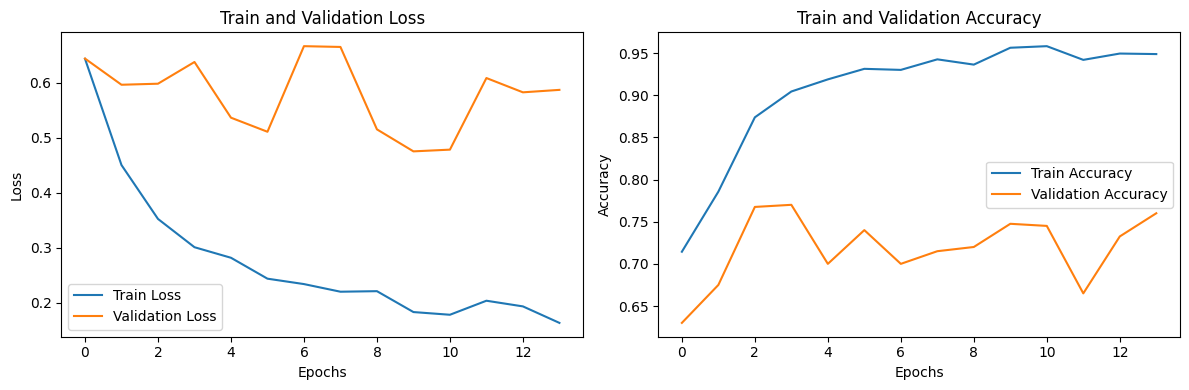

3500


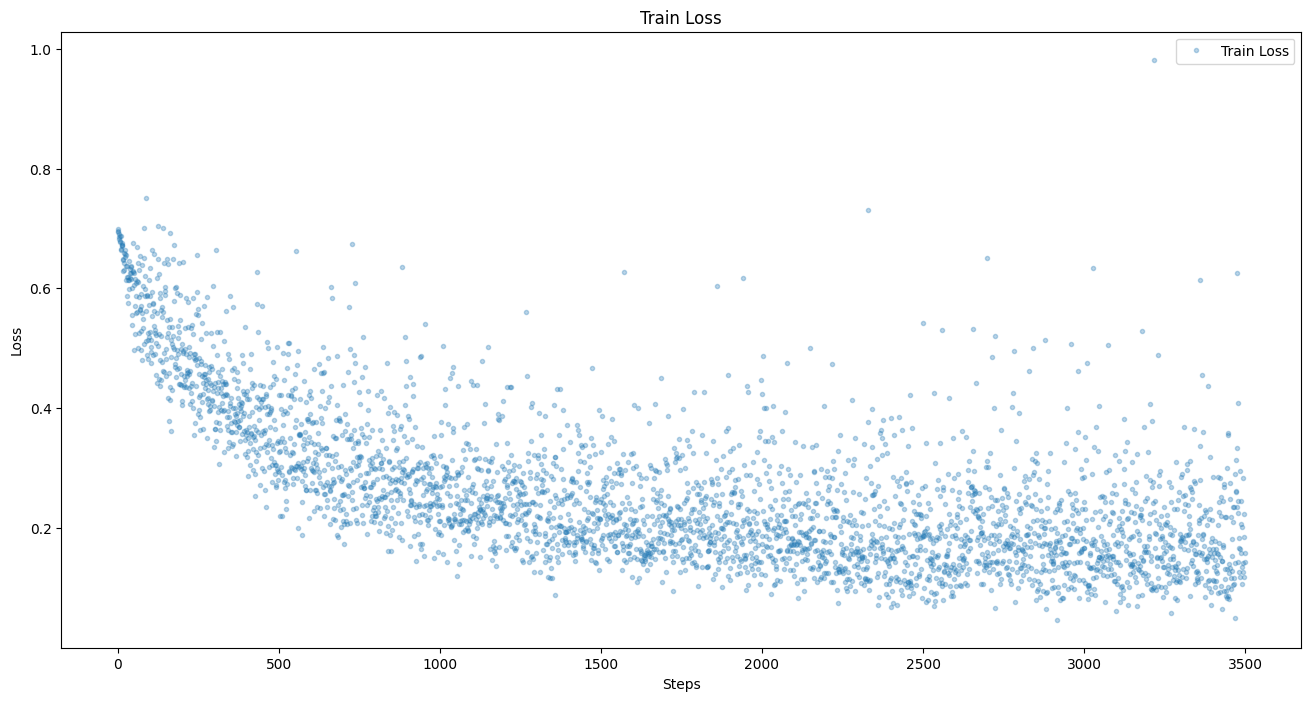

In [11]:
# Plot loss of training and validation
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train and Validation Loss')
axes[0].legend()

# Plot accuracies of training and validation
axes[1].plot(train_accuracies, label='Train Accuracy')
axes[1].plot(val_accuracies, label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Train and Validation Accuracy')
axes[1].legend()
plt.tight_layout()
plt.show()

# all train losses
print(len(all_train_losses))
# plot all_train_losses
plt.figure(figsize=(16,8))
plt.plot(all_train_losses,  '.',label='Train Loss', alpha=0.3)
#plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()
plt.show()

In [12]:
# Load the best model from pth file type
device = torch.device("cpu")
flow_models = []
for class_label in range(num_classes):
    conditioner = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, hidden_dim=hidden_dim, num_params=num_params)
    affine_coupling = AffineCouplingLayer(conditioner, split=lambda x: x.chunk(2, dim=-1)) # split the tensor into 2 parts
    flows = [affine_coupling for _ in range(num_flows)]
    latent_distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(data_dim).to(device), scale_tril=torch.eye(data_dim).to(device))

    flow_model = NormalizingFlow(latent_distribution, flows). to(device)
    #flow_model = NormalizingFlow(latent_distribution, flows).apply(init_weights).to(device)
    flow_models.append(flow_model)
best_model = PosteriorNetwork(latent_dim, flow_models, N, num_classes, y_train).to(device)
best_model.load_state_dict(torch.load('best_model_inv.pth', map_location=device)['model_state_dict'])
#best_model.eval()

<All keys matched successfully>

In [13]:
# Test best model on test data
N = N.to(device) #move num classes to device just in case
alpha_values = []
# print(next(best_model.parameters()).is_cuda)
best_model.eval()
with torch.no_grad():
    for batch_index, (X_test_batch, y_test_batch) in enumerate(test_loader):
        X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
        # Forward pass to compute alpha values for this batch
        alpha_preds = best_model(X_test_batch, N) # batch x num_classes    
        # Append the alpha values to the list
        #print(alpha_preds.shape)
        alpha_values.append(alpha_preds)

# Combine alpha values from all batches list into a single tensor
alpha_values = torch.cat(alpha_values, dim=0)
print("Alpha values shape: ", alpha_values.shape)

# Normalize alpha values
alphas_norm = F.normalize(alpha_values, p=1, dim=1) #reduce to dim 1, sum to 1

Alpha values shape:  torch.Size([400, 2])


Text(0.5, 0, 'Class')

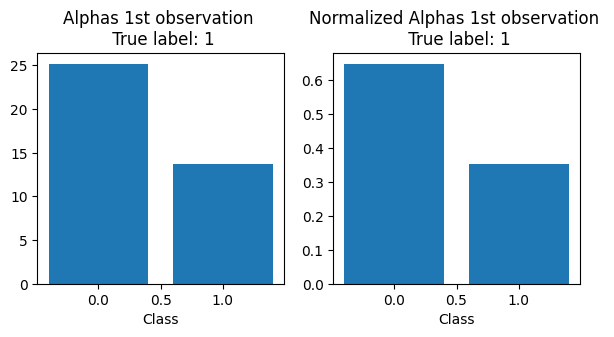

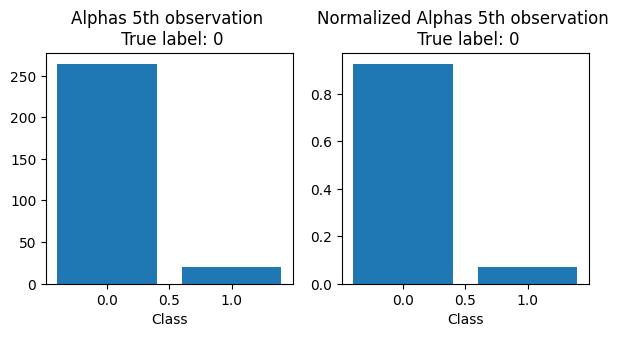

In [14]:
# Plot alpha values for the first and fifth observation
fig, ax = plt.subplots(1, 2, figsize=(7,3))
ax[0].bar(range(num_classes), alpha_values[0])
ax[0].set_title('Alphas 1st observation \n True label: {}'.format(y_test[0]))
ax[0].set_xlabel('Class')

ax[1].bar(range(num_classes), alphas_norm[0])
ax[1].set_title('Normalized Alphas 1st observation \n True label: {}'.format(y_test[0]))
ax[1].set_xlabel('Class')

fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].bar(range(num_classes), alpha_values[4])
ax[0].set_title('Alphas 5th observation \n True label: {}'.format(y_test[4]))
ax[0].set_xlabel('Class')

ax[1].bar(range(num_classes), alphas_norm[4])
ax[1].set_title('Normalized Alphas 5th observation \n True label: {}'.format(y_test[4]))
ax[1].set_xlabel('Class')

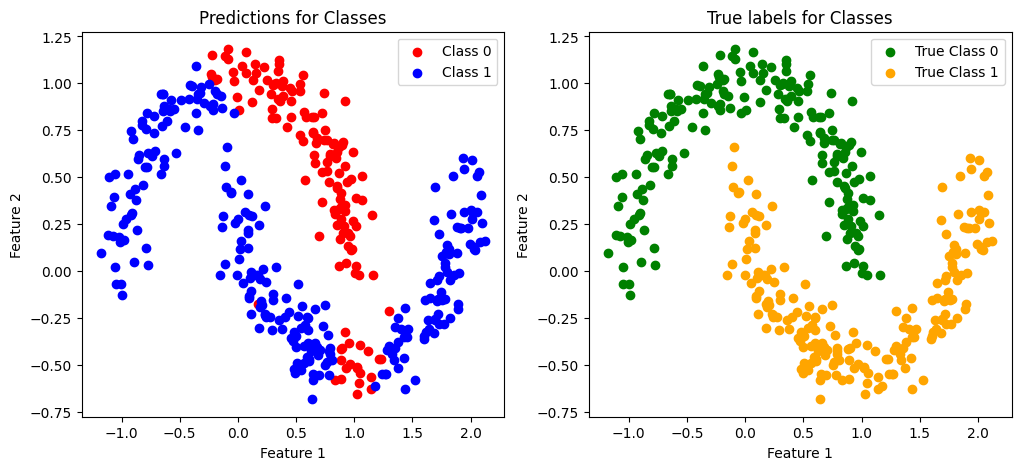

In [15]:
# Plot predications and true labels
# softmax on alpha_values to get predictions
softmax_probs = torch.softmax(alpha_values, dim=1)

# Obtain class predictions by selecting the class with the highest probability
y_preds = torch.argmax(softmax_probs, dim=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Plot class 0 true and predicted test data
axes[0].scatter(X_test[y_preds == 0][:, 0], X_test[y_preds == 0][:, 1], c='red', label='Class 0', marker='o')
axes[0].scatter(X_test[y_preds == 1][:, 0], X_test[y_preds == 1][:, 1], c='blue', label='Class 1', marker='o')
# Plot class 1 true and predicted test data
axes[1].scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], c='green', label='True Class 0', marker='o')
axes[1].scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], c='orange', label='True Class 1', marker='o')
# Add labels and legends
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('Predictions for Classes')
axes[0].legend(loc='upper right')

axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title('True labels for Classes')
axes[1].legend(loc='upper right')
plt.show()

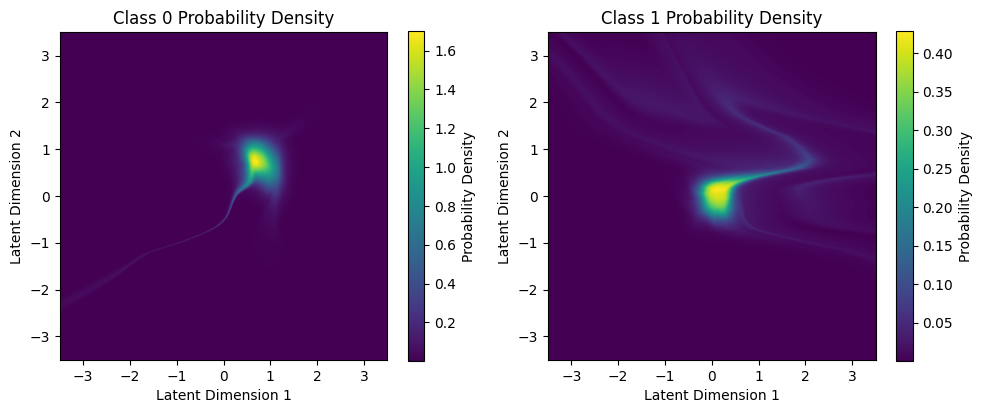

In [16]:
# Plot the meshgrid of the learned latent space
# Create a meshgrid in the latent space
nx, ny = (500, 500)
x = np.linspace(-3.5, 3.5, nx)
y = np.linspace(-3.5, 3.5, ny)
xv, yv = np.meshgrid(x, y)
mesh = np.stack((xv.flatten(), yv.flatten()), axis=1)
mesh_tensor = torch.FloatTensor(mesh).to(device)

# Compute log-probabilities for each class
logprobs = []
for class_label in range(num_classes):
    log_prob = flow_models[class_label].log_prob(mesh_tensor).clamp(min=-10, max=10)
    logprobs.append(log_prob.cpu().reshape((nx, ny)).detach().numpy())

# Plot the log probabilities as heatmaps for each class
plt.figure(figsize=(10, 4))
for class_label in range(num_classes):
    plt.subplot(1, num_classes, class_label + 1)
    plt.imshow(np.exp(logprobs[class_label]), extent=[-3.5, 3.5, -3.5, 3.5], origin='lower', cmap='viridis')
    plt.colorbar(label='Probability Density')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title(f'Class {class_label} Probability Density')
plt.tight_layout()
plt.show()

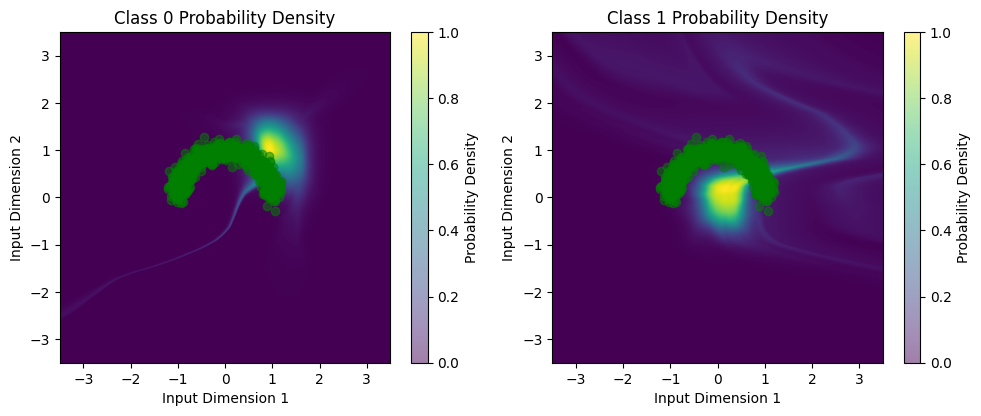

In [17]:
# Create a meshgrid in the input space
nx, ny = (500, 500)
x = np.linspace(-2.5, 2.5, nx)
y = np.linspace(-2.5, 2.5, ny)
xv, yv = np.meshgrid(x, y)
mesh = np.stack((xv.flatten(), yv.flatten()), axis=1)
mesh_tensor = torch.FloatTensor(mesh).to(device)

# Compute log-probabilities for each class
logprobs = []
for class_label in range(num_classes):
    log_prob = flow_models[class_label].log_prob(mesh_tensor).clamp(min=-10, max=10)
    logprobs.append(log_prob.cpu().reshape((nx, ny)).detach().numpy())

num_samples = 1000  # The number of samples you want to generate

posterior_samples = []
for i in range(num_classes):
    # Sample from the posterior distribution using the NormalizingFlow object
    post = best_model.flow_models[i].latent_sample(num_samples).to(device)
    posterior_samples.append(post)
generated_samples = []
for i in range(num_classes):
    # Use the generative part of the Normalizing Flow to map samples to data space
    generated = best_model.flow_models[i].g(posterior_samples[i])
    generated_samples.append(generated)


# Plot the log probabilities as heatmaps for each class
plt.figure(figsize=(10, 4))
for class_label in range(num_classes):
    plt.subplot(1, num_classes, class_label + 1)
    plt.imshow(np.exp(logprobs[class_label]), extent=[-3.5, 3.5, -3.5, 3.5], origin='lower', cmap='viridis')
    plt.colorbar(label='Probability Density')
    plt.xlabel('Input Dimension 1')    
    plt.ylabel('Input Dimension 2')
    plt.title(f'Class {class_label} Probability Density')
plt.tight_layout()
plt.show()

torch.Size([400, 2])


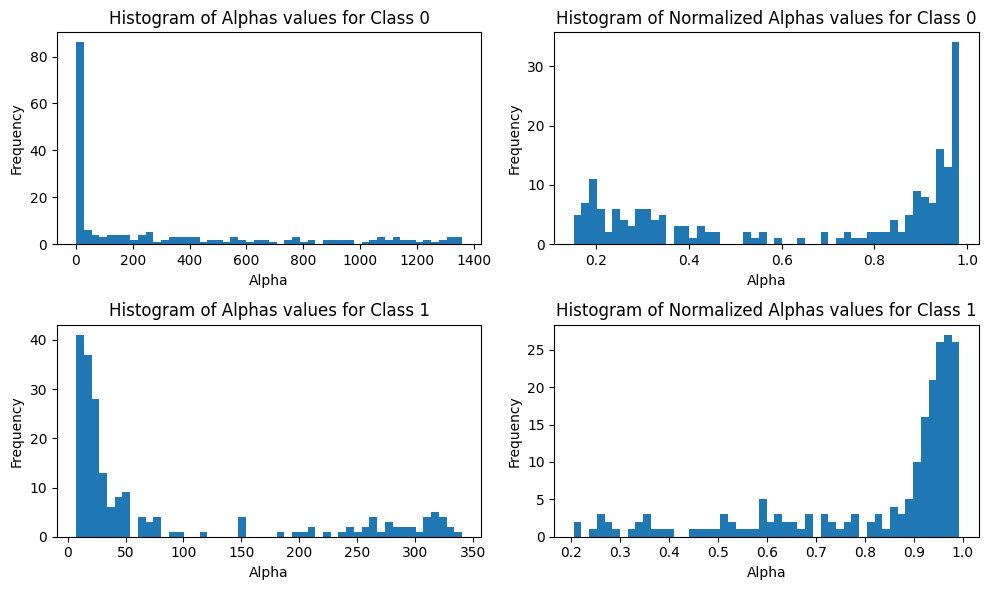

In [18]:
# Plot histograms of the alphas and normalized alphas
print(alphas_norm.shape)
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax[0,0].hist(alpha_values[y_test == 0][:,0], bins=50, label='Alpha 0', alpha=1)
#ax[0,0].hist(alpha_values[y_test == 0][:,1], bins=50, label='Alpha 1', alpha=0.5, color='red')
ax[0,0].set_title('Histogram of Alphas values for Class 0')
ax[0,0].set_xlabel('Alpha')
ax[0,0].set_ylabel('Frequency')
ax[1,0].hist(alpha_values[y_test == 1][:,1], bins=50)
ax[1,0].set_title('Histogram of Alphas values for Class 1')
ax[1,0].set_xlabel('Alpha')
ax[1,0].set_ylabel('Frequency')
ax[0,1].hist(alphas_norm[y_test == 0][:,0], bins=50)
ax[0,1].set_title('Histogram of Normalized Alphas values for Class 0')
ax[0,1].set_xlabel('Alpha')
ax[0,1].set_ylabel('Frequency')
ax[1,1].hist(alphas_norm[y_test == 1][:,1], bins=50)
ax[1,1].set_title('Histogram of Normalized Alphas values for Class 1')
ax[1,1].set_xlabel('Alpha')
ax[1,1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

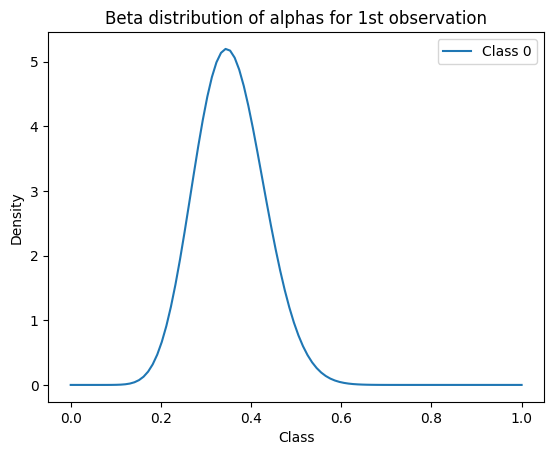

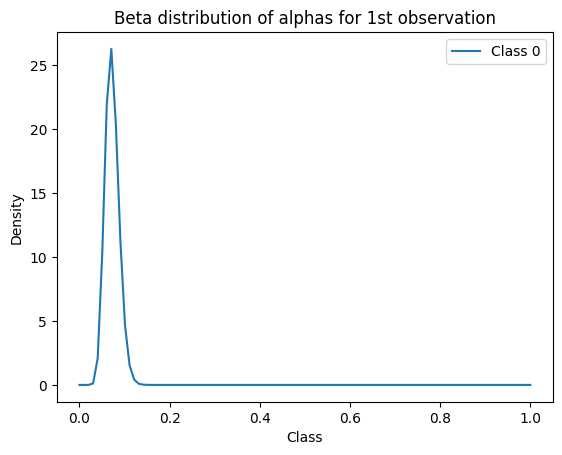

In [19]:
# Plot a beta distribution of alpha_values for the 1st and 5th observation
import scipy.stats as stats
fig, ax = plt.subplots(1, 1)
x = np.linspace(0, 1, 100)
ax.plot(x, stats.beta.pdf(x, alpha_values[0][1], alpha_values[0][0]))
ax.set_title('Beta distribution of alphas for 1st observation')
ax.set_xlabel('Class')
ax.set_ylabel('Density')
ax.legend(['Class 0', 'Class 1'])
plt.show()

import scipy.stats as stats
fig, ax = plt.subplots(1, 1)
x = np.linspace(0, 1, 100)
ax.plot(x, stats.beta.pdf(x, alpha_values[4][1], alpha_values[4][0]))
ax.set_title('Beta distribution of alphas for 1st observation')
ax.set_xlabel('Class')
ax.set_ylabel('Density')
ax.legend(['Class 0', 'Class 1'])
plt.show()

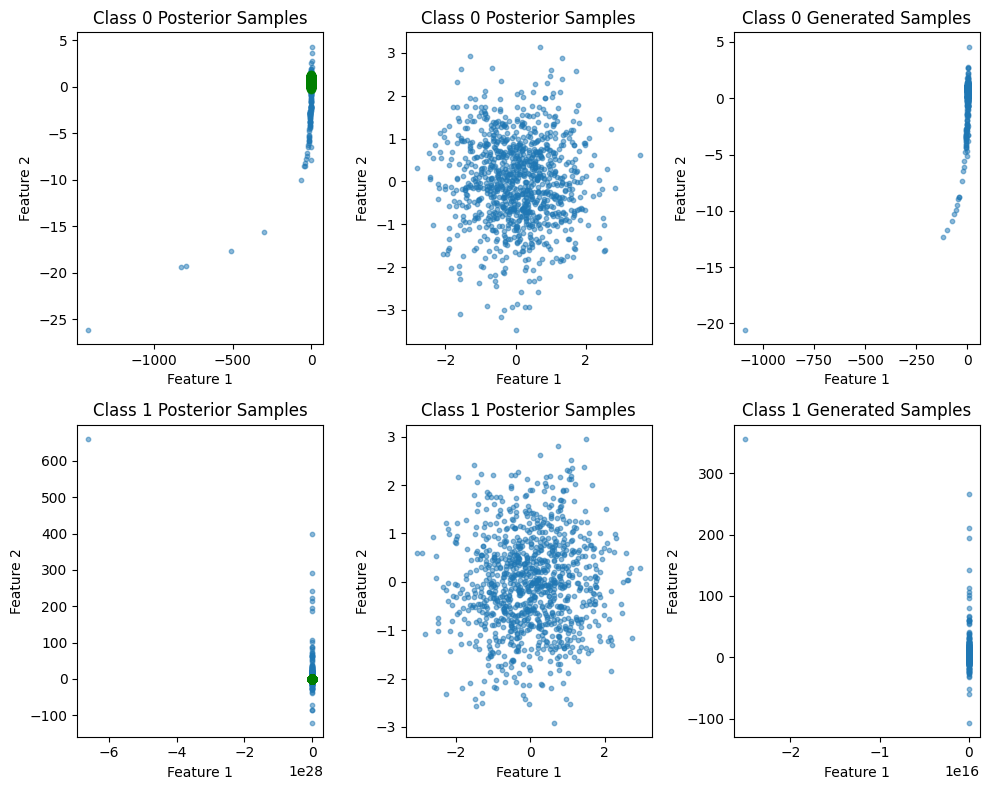

In [20]:

# Generate samples from the flows posterior distribution
num_samples = 1000
samples = []
posterior_samples, generated_samples = [], []
for i in range(num_classes):
    samples.append(best_model.flow_models[i].sample(num_samples).to(device))
    # Sample from the posterior distribution using the NormalizingFlow object
    post = best_model.flow_models[i].latent_sample(num_samples).to(device)
    posterior_samples.append(post)
    #Use the generative part of the Normalizing Flow to map samples to data space
    generated_samples.append(best_model.flow_models[i].g(post))

# Create subplots for each class
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
for i, ax_row in enumerate(axes):
    ax_row[0].scatter(samples[i][:, 0].numpy(), samples[i][:, 1].numpy(), s=10, alpha=0.5)
    ax_row[0].scatter(X_train[y_train == i][:, 0], X_train[y_train == i][:, 1], c='green', label='True Class 0', marker='o', alpha=0.5)

    ax_row[0].set_xlabel('Feature 1')
    ax_row[0].set_ylabel('Feature 2')
    ax_row[0].set_title(f'Class {i} Posterior Samples')

    ax_row[1].scatter(posterior_samples[i][:, 0].numpy(), posterior_samples[i][:, 1].numpy(), s=10, alpha=0.5)
    ax_row[1].set_xlabel('Feature 1')
    ax_row[1].set_ylabel('Feature 2')
    ax_row[1].set_title(f'Class {i} Posterior Samples')

    ax_row[2].scatter(generated_samples[i][:, 0].numpy(), generated_samples[i][:, 1].numpy(), s=10, alpha=0.5)
    ax_row[2].set_xlabel('Feature 1')
    ax_row[2].set_ylabel('Feature 2')
    ax_row[2].set_title(f'Class {i} Generated Samples')
plt.tight_layout()
plt.show()

ValueError: 'c' argument has 1600 elements, which is inconsistent with 'x' and 'y' with size 1000.

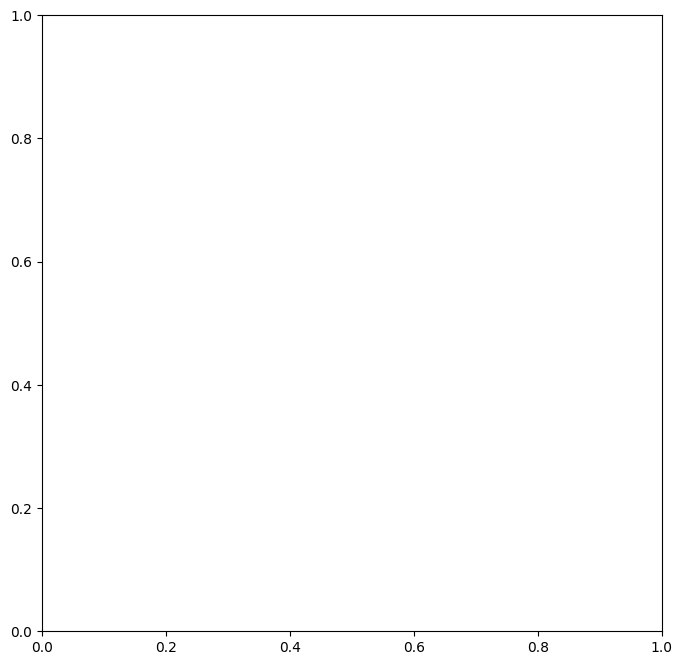

In [21]:
# Explore feature space
def plot_latent_space(flow_model, num_samples, class_label):
    z = flow_model.latent_sample(num_samples)
    x = flow_model.g(z)
    x = x.detach().cpu().numpy()
    z = z.detach().cpu().numpy()
    plt.figure(figsize=(8, 8))
    plt.scatter(z[:, 0], z[:, 1], c=class_label, cmap='tab10', alpha=0.5)
    plt.title('Latent space')
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.scatter(x[:, 0], x[:, 1], c=class_label, cmap='tab10', alpha=0.5)
    plt.title('Feature space')
    plt.show()

plot_latent_space(best_model.flow_models[0], 1000, y_train)

In [ ]:
# Generate samples from the trained models
num_samples_gen_per_class = 500
generated_samples = []
with torch.no_grad():
    for class_label in range(num_classes):
        samples = flow_models[class_label].sample(num_samples=num_samples_gen_per_class).cpu().numpy()
        generated_samples.append(samples)
generated_samples = np.array(generated_samples)
print("Generated samples shape: ", generated_samples.shape)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Plot Class 0
axes[0].scatter(X_train[0, :, 0], X_train[0, :, 1], color='r', alpha=0.6, label='Class 0')
axes[0].scatter(generated_samples[0, :, 0], generated_samples[0, :, 1], color='g', alpha=0.6, label='Generated Class 0')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('Class 0 vs. Generated Class 0')
axes[0].legend()

# Plot Class 1
axes[1].scatter(X_train[1, :, 0], X_train[1, :, 1], color='b', alpha=0.6, label='Class 1')
axes[1].scatter(generated_samples[1, :, 0], generated_samples[1, :, 1], color='g', alpha=0.6, label='Generated Class 1')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title('Class 1 vs. Generated Class 1')
axes[1].legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train[0, :, 0],X_train[0, :, 1], color='r', alpha=0.6, label='Class 0')
plt.scatter(generated_samples[0, :, 0], generated_samples[0, :, 1], color='g', alpha=0.5, label='Generated Class 0')
plt.scatter(X_train[1, :, 0], X_train[1, :, 1], color='b', alpha=0.6, label='Class 1')
plt.scatter(generated_samples[1, :, 0], generated_samples[1, :, 1], color='y', alpha=0.5, label='Generated Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Class 0 vs. Generated Class 0')
plt.legend()

In [ ]:
nx, ny = (100, 100)
x = np.linspace(-4, 4, nx)
y = np.linspace(-4, 4, ny)
xv, yv = np.meshgrid(x, y)
mesh = np.stack((xv.flatten(), yv.flatten()),axis=1)
mesh_tensor = torch.FloatTensor(mesh).to(device)
print(mesh_tensor.shape)

# class 0
logprobs = flow_models_trained[0].log_prob(mesh_tensor).clamp(min=-10, max=10)
logprobs = logprobs.cpu().reshape((100,100)).detach().numpy()
# class 1
logprobs2 = flow_models_trained[1].log_prob(mesh_tensor).clamp(min=-10, max=10)
logprobs2 = logprobs2.cpu().reshape((100,100)).detach().numpy()


# Plot the log probability as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(np.exp(logprobs), extent=[-4,4,-4,4], origin='lower', cmap='viridis')
plt.scatter(X_train[0, :, 0], X_train[0, :, 1], label='Original Data', alpha=0.07, color='red')
plt.colorbar(label='Probability Density')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Probability Density Function')
plt.show()


plt.figure(figsize=(8, 6))
plt.imshow(np.exp(logprobs2), extent=[-4,4,-4,4], origin='lower', cmap='viridis')
plt.scatter(X_train[1, :, 0], X_train[1, :, 1], label='Original Data', alpha=0.07, color='red')
plt.colorbar(label='Probability Density')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Probability Density Function')
plt.show()

#logprobs = flow_models[class_label].log_prob(X_tensor2)

# logprobs = logprobs.reshape((100,100))
#logprobs = logprobs.cpu().reshape((100,100)).detach().numpy()
# plt.figure(figsize = (8,8))
# plt.imshow(np.exp(logprobs), origin='lower', extent=[5,15,5,15])

# class_label = 1
# with torch.no_grad():
#     samples_c1 = flow_models[class_label].sample(num_samples=num_samples_gen_per_class).cpu().numpy()

# #plt.scatter(synthetic_data[:, 0],synthetic_data[:, 1], label='Generated Samples', alpha=0.05, color='yellow')
# plt.scatter(X_train[:, 0], X_train[:, 1], label='Original Data', alpha=0.07, color='red')
# plt.legend()
# plt.show()